In [1]:

import numpyro as ny
import numpyro.distributions as dist
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import numpy as onp
import jax.numpy as np
from jax.random import PRNGKey
# from jax.config import config
from jax import jit, grad, lax, random, vmap
from jax.ops import index_update, index, index_add

In [3]:
n_nodes = 100
n_edges = n_nodes*(n_nodes-1)//2



trans_times = onp.random.geometric(
    onp.random.beta(2,5,size=(n_edges,)),
    size=(n_edges,)
)

# pd.Series(trans_times.flatten()).plot.hist(bins=range(30))
# trans_times.flatten()

In [4]:
def squareform(edgelist, n=n_nodes):
    empty = onp.zeros((n,n))
    empty[onp.triu_indices(n,1)] = edgelist
    return empty+empty.T



In [5]:
# a = jax_squareform(trans_times)  # transition times
g = nx.connected_watts_strogatz_graph(n_nodes,4, 0.1)




Text(0.5, 1.0, '"True" transmission matrix')

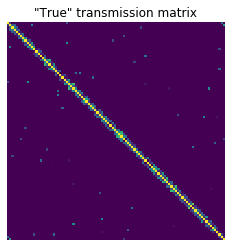

In [6]:
u = onp.array([1]+(n_nodes-1)*[0])
p = (
    onp.identity(n_nodes)+
    squareform(onp.random.beta(2,5,size=(n_edges,)))
    *nx.to_numpy_array(g)
)

plt.imshow(p)
plt.axis('off')
plt.title('"True" transmission matrix')

In [7]:
def not_not(a,b):
    return 1 - onp.multiply(1-a, 1-b)

# modified https://arxiv.org/pdf/1511.01062.pdf
def spread(p,u,t, T=5):
#     u_p = onp.clip(u + p@u, 0,1)  # clamp from paper
#     u_p = onp.clip(1-(1-u)*(1-u_add), 0,1)  # last term of conv?
#     u_add = p@u  # grows uncontrollably
    u_add = np.tanh(p@u)
    u_p = not_not(u, u_add)
    
    if t==T:
        return u_p
    else:
        return spread(p,u_p, t+1, T)
# spread(p,u,0, T=5)
# 1-(1-p)@(u), p@u
# p@(2*u*(1-u/2))
spread(p,u,0, T=5)


array([1.00000000e+00, 9.99998529e-01, 9.97844407e-01, 9.98030835e-01,
       9.01500577e-01, 8.26681447e-01, 4.56140071e-01, 6.71678476e-01,
       8.82129735e-01, 9.99938027e-01, 9.83601658e-01, 9.99973264e-01,
       9.91504183e-01, 1.23922809e-01, 1.88590126e-01, 8.48308529e-02,
       9.01954768e-03, 6.97608573e-02, 4.02144501e-02, 3.23998863e-01,
       3.32993123e-01, 7.89285268e-01, 3.20546201e-01, 1.21095097e-01,
       7.23618026e-01, 7.16716507e-01, 9.97885429e-01, 9.99995161e-01,
       9.99916372e-01, 9.59752938e-01, 9.92949789e-01, 6.79575210e-01,
       1.08446081e-01, 1.10144109e-01, 6.42359257e-03, 4.31280699e-03,
       3.29938852e-03, 5.71495209e-02, 9.91477752e-02, 3.39530895e-01,
       5.99793924e-02, 2.61494480e-03, 5.04943191e-03, 9.37788905e-03,
       1.20125664e-03, 1.86982858e-03, 2.04807598e-02, 5.65508718e-03,
       1.97586294e-01, 5.14039728e-02, 1.23543829e-01, 2.81156700e-01,
       4.12196379e-01, 7.89778363e-01, 8.72753457e-02, 2.50012446e-01,
      

In [8]:
## realize
onp.random.binomial(1, _)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

## Synth Data 

In [9]:
n_obs = 200
sources = onp.random.choice(n_nodes, size=(n_obs,1))
init = onp.zeros((n_obs, n_nodes))
onp.put_along_axis(init,sources, 1, 1)

plt.subplot(131)
plt.spy(init)
plt.xlabel('source')
# plt.axis('off')

realize = lambda x, T: onp.random.binomial(1, spread(p, x, 0, T))
infections = np.stack([realize(i, 5) for i in init])

plt.subplot(132)
plt.title('USE T=5')
plt.spy(infections)
plt.xlabel('infected@T=5')

plt.subplot(133)

plt.spy(np.stack([realize(i, 5) for i in infections]))
plt.xlabel('infected@T=10')

for ax in plt.gcf().get_axes():
    ax.set_ylabel('obs. n')
    ax.set_xticks([])
    ax.set_yticks([]);

So that worked, one different initial infection for each cascade

## Numpyro inference

kind of modeled after 
- [deterministic time-series functions](https://pyro.ai/numpyro/time_series_forecasting.html)
- [plates](https://pyro.ai/numpyro/examples/baseball.html)

```python
def spread_jax(p,u,t,T):
    '''modified https://arxiv.org/pdf/1511.01062.pdf'''
    u_add = lax.tanh(p@u)
    u_p = 1-(1-u)*(1-u_add)
    
    if t>=T:
        return u_p
    else:
        return spread_jax(p, u_p, t+1, T)
```

In [12]:
@jit 
def jax_squareform(edgelist, n=n_nodes):
    """edgelist to adj. matrix"""
    empty = np.zeros((n,n))
    half = index_add(empty, index[np.triu_indices(n,1)], edgelist)
    full = half+half.T
    return full

def get_source(weights):
    empty = np.zeros_like(weights)
    max_idx = np.argmax(weights)
    return index_add(empty, index[max_idx], 1)

def spread_jax(p,u_init,T):
    """
    modified https://arxiv.org/pdf/1511.01062.pdf
    p: transmission probability matrix
    u_init: initial infection node states
    T: num. iterations to observe at
    """
    def scan_fn(u, t):
        u_add = lax.tanh(np.matmul(p,u))  # from neighbors
        u_p = 1-(1-u)*(1-u_add)  # combine with self
        return u_p, u_add
    u_end, u_adds = lax.scan(
        scan_fn, u_init, np.arange(T) 
    )
    return u_end, u_adds

def diff_kg(infections):
    n_cascades, n_nodes  = infections.shape
    n_edges = n_nodes*(n_nodes-1)//2 # complete graph
        
    # node initial infection, relative probability
    ϕ = ny.sample("ϕ", dist.Dirichlet(np.ones(n_nodes))) 
    
    # beta hyperpriors
    u = ny.sample("u", dist.Uniform(np.zeros(n_edges), 
                                         np.ones(n_edges)))
    v = ny.sample("v", dist.Gamma(np.ones(n_edges),
                                       20*np.ones(n_edges)))
    
    ## Bayesian Inference and Decision Theory, Dr. Laskey (GMU)
    Λ = ny.sample("Λ", dist.Beta(u*v, (1-u)*v))
    s_ij = jax_squareform(Λ)  # adjacency matrix to recover via inference
    
    with ny.plate("n_cascades", n_cascades):
        # infer source node
        x0 = ny.sample("x0", dist.Categorical(ϕ))  # issue#542->GumbelSoftmax?
        # simulate ode and realize
        infectious, hist = spread_jax(s_ij, x0, 5)
        numpyro.sample("obs", dist.Bernoulli(probs=infectious), 
                       obs=infections)

In [13]:
kernel = ny.infer.NUTS(diff_kg)
mcmc = ny.infer.MCMC(kernel, num_warmup=1500, num_samples=3000)
mcmc.run(PRNGKey(0), infections)
mcmc.print_summary()
samples = mcmc.get_samples()

TypeError: dot_general requires contracting dimensions to have the same shape, got [100] and [200].

In [29]:


run_inference(diff_kg, cascades, jax.random.PRNGKey(0), args)

NotImplementedError: 

## OLD stuff

In [7]:
@jit
def countdown(s_ij, x, step):
    t_minus = s_ij - step*x
    sym = lax.min(t_minus, t_minus.T)
    return lax.max(sym, 0.)  # no neg. times


@jit
def infect(state, step=1):
    neighbor_set = state.s_ij*state.x  # who knows an infected node?
    getting_infected=np.any(neighbor_set==1, axis=1) # and is getting infected now?
    x_p = lax.clamp(0,state.x+getting_infected, 1) # update infections
    s_ij_p = countdown(state.s_ij, x_p, step)  # and time-left
    
    return InfectState(x=x_p, s_ij=s_ij_p), step  # new state

# print(infect(InfectState(x0, a))[0].x)
# %timeit infect(InfectState(x0, a))


In [8]:
import functools

@functools.partial(jit, static_argnums=(1,2,3))
def _pandemic_scan(state, step, t, T):
    return lax.scan(
        infect, 
        InfectState(x0, a), 
        np.full(T,step)
    )

def pandemic_scan(state, step=1, t=0, T=5):
    return _pandemic_scan(state, step, t, T)[0]

# %timeit pandemic_scan(InfectState(x0, a), T=5).x.block_until_ready()

In [9]:
def pandemic(state, step=1, t=0, T=5):
    state_p, _ = infect(state, step=step)

    if t==T:
        return state_p
    elif (t>=0) and (t<T):
        return pandemic(state_p, t=t+step)
    else:
        print('INVALID t!')
        
# %timeit pandemic(InfectState(x0, a), T=5).x.block_until_ready()

In [10]:
# state_p, _ = pandemic_scan(InfectState(x0, a), T=10)
from functools import partial

def final_infected(s_ij, x, T=5):
    state=InfectState(x, s_ij)
    return pandemic_scan(state, T=T).x

# final_infected(a, x0, T=10)

def infect_on_network(s_ij, **kws):
    return partial(final_infected, s_ij, **kws)
# print(state_p.x)

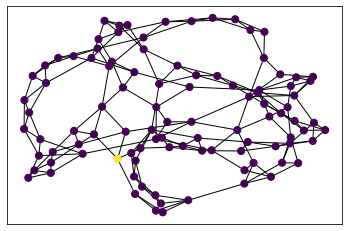

In [11]:
a = lax.mul(jax_squareform(trans_times), nx.to_numpy_array(g))  # transition times
x0 = np.array([1]+(n_nodes-1)*[0])  # infect state

nx.set_node_attributes(g, x0, name='state')


from collections import namedtuple
# (infected?, time-left-per-neighbor?)
InfectState = namedtuple('InfectState', ['x', 's_ij'])

a,x0



plt.figure()
pos = nx.layout.fruchterman_reingold_layout(g)
nx.draw_networkx(g,  node_color=x0, pos=pos, with_labels=False, node_size=50)

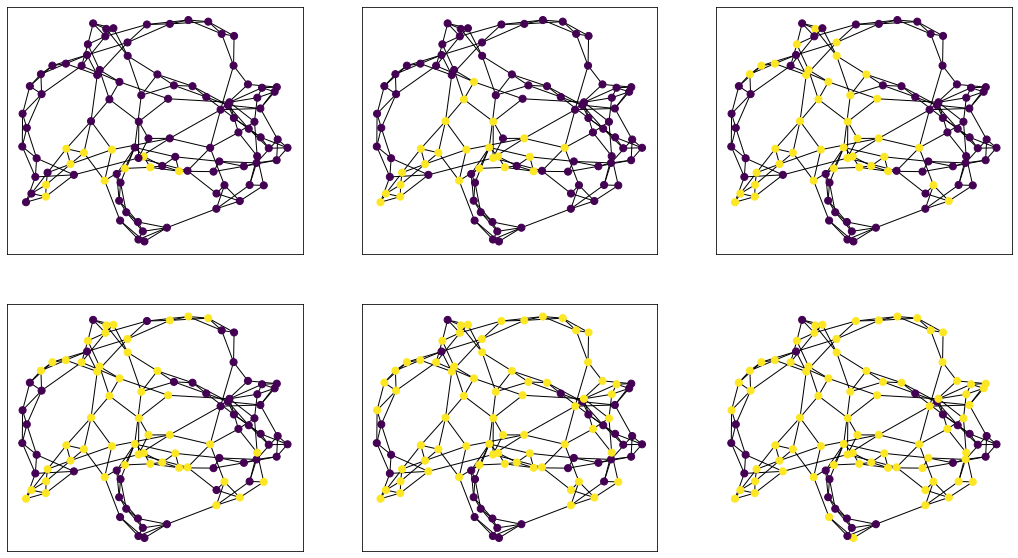

In [14]:
f,ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))

for n,axis in enumerate(ax.flatten()):
    state_p = pandemic_scan(InfectState(x0, a), T=(n+1)*5)
#     infected = infect_on_network(a)(x0, T=(n+1)*5)
    infected = state_p.x
    nx.draw_networkx(g,  node_color=infected, ax=axis, pos=pos, with_labels=False, node_size=50)
    plt.axis('off')